In [130]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import folium
from folium import plugins

from sklearn.cluster import DBSCAN

import time
import random
from statistics import mean, median
from math import radians, cos, sin, asin, sqrt
import os

In [58]:
# I implemented some functions in a python file `auxiliary_functions.py`
from auxiliary_functions import *

The following allows `Kepler` plots to be enabled on Jupyter notebook.

In [3]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager keplergl-jupyter

In [4]:
GEOLIFE_DATA_PATH =r"C:\Users\Tay\Documents\GitHub\Trajectory-Data-Mining\Geolife Trajectories 1.3\Data"

In [5]:
users = os.listdir(GEOLIFE_DATA_PATH)
print("Number of users in Geolife dataset: " + str(len(users)))

Number of users in Geolife dataset: 182


# Importing trajectories from Geolife dataset
Some things I changed:
- According to the User Guide from Microsoft, the 3rd column is all set to 0 and the 3rd last column is the number of days that has passed since 12/30/1899, both not useful to me.
- Merged the `date` and `time` together and cast the datetime type onto them.

Note
- `time` is in GMT+0 for all their datetime data.
- `alt` = -777 means that the altitude isn't available.

In [6]:
def readUserTraj(path_to_user):
    '''
    :param path_to_user: a path to the user's dataset according to the Geolife dataset file system
    :return: a dataframe containing all of the user's trajectories
    '''
    trajs = os.listdir(path_to_user + r"\Trajectory")
    col_names = ["lat", "lon", "alt", "date", "time"]
    userTraj = pd.DataFrame(columns=["lat", "lon", "alt", "time"])
    
    for i in range(len(trajs)):
        TRAJ_PATH = path_to_user + r"\Trajectory" + r"\\" + trajs[i]
        traj = pd.read_csv(TRAJ_PATH, skiprows=6, header=None, usecols=[0,1,3,5,6], names=col_names)

        # to combine date and time and change it to `datetime` type
        for i in range(len(traj)):
            traj.loc[i, "time"] = pd.to_datetime(traj.loc[i, "date"] + " " + traj.loc[i, "time"])

        traj = traj.drop(columns="date")
        userTraj = userTraj.append(traj)
    
    userTraj = userTraj.reset_index(drop=True)
    
    return userTraj

In [32]:
%%time
trajDataFrames = [readUserTraj(GEOLIFE_DATA_PATH + r"\\" + users[i]) for i in range(5)]

Wall time: 21min 42s


In [33]:
trajDataFrames[0]

,lat,lon,alt,time
0,39.984702,116.318417,492,2008-10-23 02:53:04
1,39.984683,116.318450,492,2008-10-23 02:53:10
2,39.984686,116.318417,492,2008-10-23 02:53:15
3,39.984688,116.318385,492,2008-10-23 02:53:20
4,39.984655,116.318263,492,2008-10-23 02:53:25
...,...,...,...,...
173865,40.000403,116.327255,149,2009-07-05 07:44:55
173866,40.000433,116.327209,150,2009-07-05 07:45:00
173867,40.000443,116.327186,150,2009-07-05 07:45:05
173868,40.000522,116.327132,149,2009-07-05 07:45:10


In [34]:
trajDataFrames[1]

,lat,lon,alt,time
0,39.984094,116.319236,492,2008-10-23 05:53:05
1,39.984198,116.319322,492,2008-10-23 05:53:06
2,39.984224,116.319402,492,2008-10-23 05:53:11
3,39.984211,116.319389,492,2008-10-23 05:53:16
4,39.984217,116.319422,491,2008-10-23 05:53:21
...,...,...,...,...
108602,39.977969,116.326651,311,2008-12-15 00:30:58
108603,39.977946,116.326653,310,2008-12-15 00:31:03
108604,39.977897,116.326624,310,2008-12-15 00:31:08
108605,39.977882,116.326626,310,2008-12-15 00:31:13


In [35]:
trajDataFrames[2]

,lat,lon,alt,time
0,39.927938,116.338967,492,2008-10-23 12:45:23
1,39.927527,116.338899,492,2008-10-23 12:45:24
2,39.926516,116.338048,401,2008-10-23 12:45:54
3,39.926496,116.338094,380,2008-10-23 12:45:59
4,39.926498,116.338140,365,2008-10-23 12:46:04
...,...,...,...,...
248212,39.989629,116.222151,118,2009-03-22 08:13:23
248213,39.989583,116.222194,114,2009-03-22 08:13:28
248214,39.989542,116.222221,112,2009-03-22 08:13:30
248215,39.989514,116.222292,110,2009-03-22 08:13:34


In [36]:
trajDataFrames[3]

,lat,lon,alt,time
0,39.999844,116.326752,492,2008-10-23 17:58:54
1,39.999876,116.326708,492,2008-10-23 17:58:59
2,39.999915,116.326672,492,2008-10-23 17:59:04
3,40.000059,116.327140,142,2008-10-23 17:59:09
4,40.000039,116.327172,132,2008-10-23 17:59:14
...,...,...,...,...
485221,40.000403,116.327255,149,2009-07-05 07:44:55
485222,40.000433,116.327209,150,2009-07-05 07:45:00
485223,40.000443,116.327186,150,2009-07-05 07:45:05
485224,40.000522,116.327132,149,2009-07-05 07:45:10


In [37]:
trajDataFrames[4]

,lat,lon,alt,time
0,39.999974,116.327149,143,2008-10-23 17:58:52
1,40.000011,116.327161,126,2008-10-23 17:58:58
2,40.000008,116.327135,135,2008-10-23 17:59:03
3,40.000016,116.327126,135,2008-10-23 17:59:08
4,40.000003,116.327098,141,2008-10-23 17:59:13
...,...,...,...,...
439392,39.999916,116.327657,605,2009-07-29 06:15:51
439393,39.999934,116.327693,610,2009-07-29 06:15:56
439394,39.999803,116.327442,573,2009-07-29 06:16:01
439395,39.999790,116.327409,572,2009-07-29 06:16:06


Plotting of the trajectory for user 000

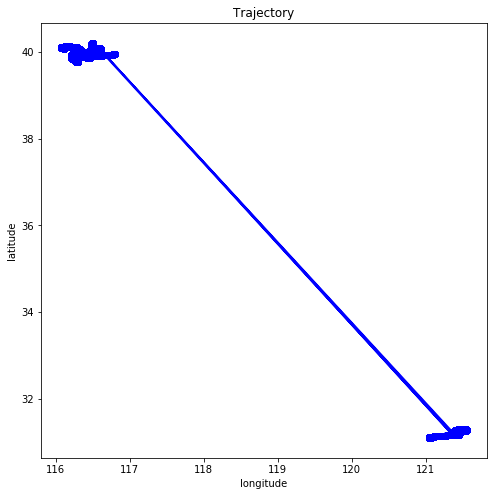

In [38]:
plot_traj(trajDataFrames[0])

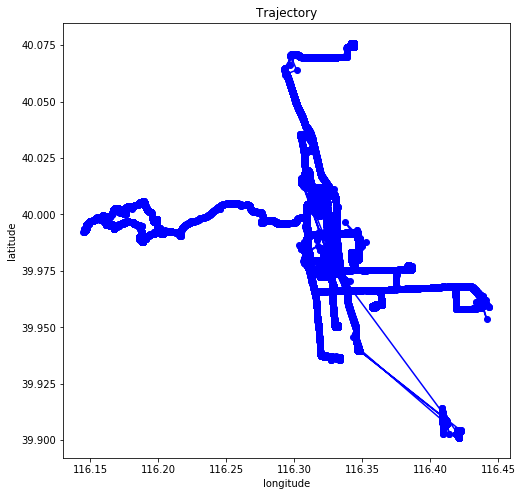

In [39]:
plot_traj(trajDataFrames[1])

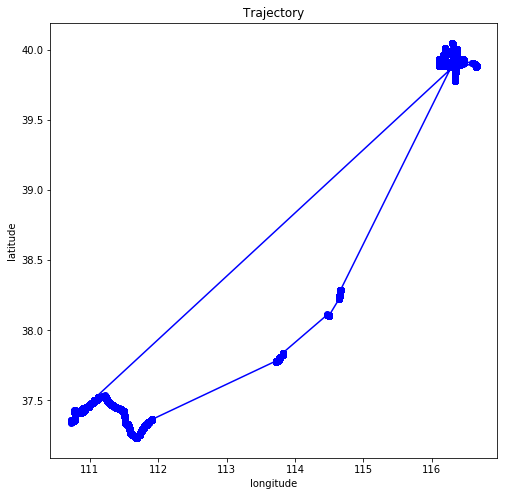

In [40]:
plot_traj(trajDataFrames[2])

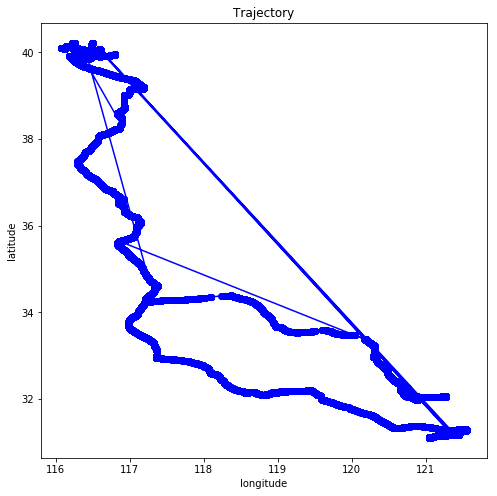

In [41]:
plot_traj(trajDataFrames[3])

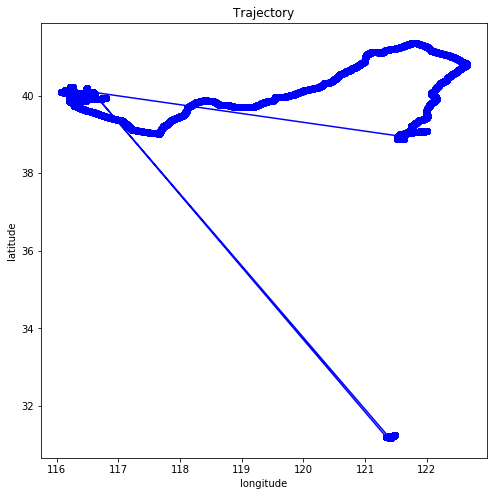

In [42]:
plot_traj(trajDataFrames[4])

In [213]:
# m = folium.Map([40, 116.5], zoom_start=10)

# for index, row in traj000.iterrows():
#     folium.CircleMarker([row['lat'], row['lon']],
#                             radius=0.001,
#                             fill_color="#3db7e4", # divvy color
#                            ).add_to(m)

# # plot heatmap
# # m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

# m

# Noise Filtering with mean and median filter

In [10]:
traj = genTrajectory(NUM_POINTS=100)
traj.head()

,lon,lat,time,inacc_radius
0,101.545502,3.212502,424.682580,3.936337
1,100.118732,2.428656,308.492832,86.765358
2,107.475941,3.868894,383.240863,48.296474
3,107.497242,2.203568,479.966188,88.894837
4,109.971438,0.219211,170.367053,82.606632


## Comparing the performance of mean filter and median filter

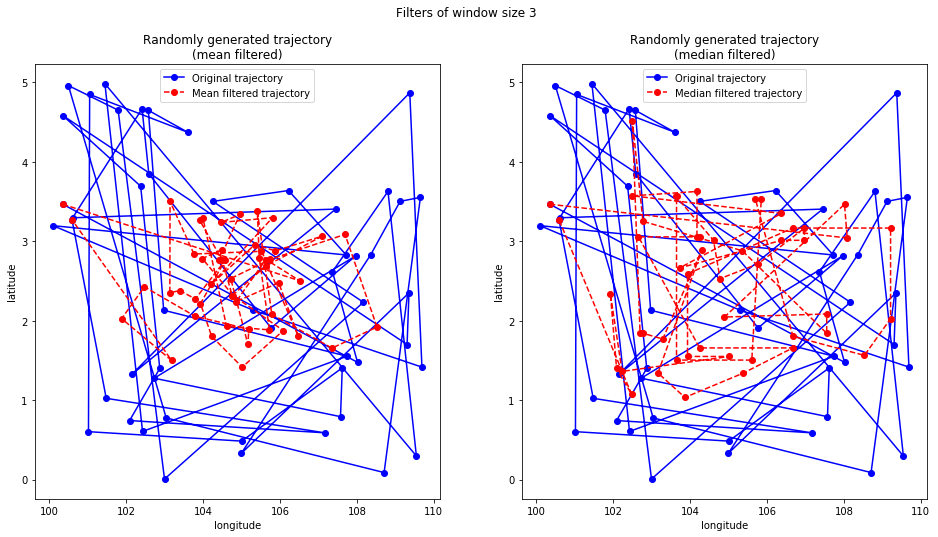

In [11]:
traj = genTrajectory(NUM_POINTS=50)

mean_traj = getFilteredTraj(traj, filter_type="mean")
median_traj = getFilteredTraj(traj, filter_type="median")

plot_filtered_traj(traj, mean_traj, median_traj, window_size=3)

# Stay Point Detection Algorithm

In the paper, the authors set `distThres` = 200 (metres) and `timeThres` = 30\*60 (seconds).

200 metres is roughly the length/breath of a small restaurant/house and longer than insignificant locations like bus stops and traffic lights.

Note that the first 5 users have 1.5 million datapoints combined, the following algorithm runs in linear time and takes less than 25 mins to find the stay points for 1.5 million points.

In [59]:
%%time
stayPointsList = [SPDA(trajDataFrames[i], distThres=200, timeThres=30*60, minPoints=50)
                  for i in range(len(trajDataFrames))]

Wall time: 18min 7s9396                                                                                                                                                


In [60]:
for i in range(len(stayPointsList)):
    print("Number of staypoints for user 00" + str(i) + ": " + str(len(stayPointsList[i])))

Number of staypoints for user 000: 42
Number of staypoints for user 001: 52
Number of staypoints for user 002: 9
Number of staypoints for user 003: 75
Number of staypoints for user 004: 136


Plot each user's stay points

Looks like most people were from Tsinghua University and occasionally travel to Shanghai.

In [127]:
stayPoints000Map = folium.Map([40, 116.5], zoom_start=6)

for stayPoint in stayPointsList[0]:
    folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                            radius=10,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(stayPoints000Map)

# plot heatmap
# m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

stayPoints000Map

NameError: name 'folium' is not defined

In [62]:
stayPoints001Map = folium.Map([40, 116.5], zoom_start=6)

for stayPoint in stayPointsList[1]:
    folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                            radius=10,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(stayPoints001Map)

# plot heatmap
# m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

stayPoints001Map

In [63]:
stayPoints002Map = folium.Map([40, 116.5], zoom_start=6)

for stayPoint in stayPointsList[2]:
    folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                            radius=10,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(stayPoints002Map)

# plot heatmap
# m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

stayPoints002Map

In [64]:
stayPoints003Map = folium.Map([40, 116.5], zoom_start=6)

for stayPoint in stayPointsList[3]:
    folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                            radius=10,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(stayPoints003Map)

# plot heatmap
# m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

stayPoints003Map

In [65]:
stayPoints004Map = folium.Map([40, 116.5], zoom_start=6)

for stayPoint in stayPointsList[4]:
    folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                            radius=10,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(stayPoints004Map)

# plot heatmap
# m.add_child(plugins.HeatMap(valid_df[['y', 'x']].to_numpy(), radius=15))

stayPoints004Map

Plotting all the staypoints in 1 map

In [66]:
stayPointsMap = folium.Map([40, 116.5], zoom_start=5)

colors = ["red", "blue", "green", "orange", "gray"]

for i in range(len(stayPointsList)):
    for stayPoint in stayPointsList[i]:
        folium.CircleMarker([stayPoint.location[1], stayPoint.location[0]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointsMap)

stayPointsMap

## Clustering the stay points

Here we use DBSCAN to do clustering, we experiment with some values of `eps`.

First we collect all the stay points in a dataframe for easier data processing.

In [92]:
stayPoints_df = pd.DataFrame(columns=["UserID", "lat", "lon", "arrivalTime", "departTime", 
                                      "startIndex", "endIndex","ClusterID"])

for i in range(len(stayPointsList)):
    for j in range(len(stayPointsList[i])):
        point = stayPointsList[i][j]
        stayPoints_df.loc[stayPoints_df.shape[0], :] = [i, point.location[1], point.location[0], 
                                                         point.arrivalTime, point.departTime,
                                                         point.startIndex, point.endIndex, np.nan]

In [93]:
stayPoints_df

,UserID,lat,lon,arrivalTime,departTime,startIndex,endIndex,ClusterID
0,0,39.9958,116.287,2008-10-23 03:05:15,2008-10-23 04:08:42,147,150,NaN
1,0,39.917,116.326,2008-10-23 04:34:52,2008-10-27 11:59:09,469,1930,NaN
2,0,40.0088,116.297,2008-10-27 11:59:49,2008-10-28 02:55:56,1937,3395,NaN
3,0,39.9801,116.327,2008-10-28 02:57:26,2008-11-03 10:13:36,3414,3627,NaN
4,0,39.9968,116.326,2008-11-03 10:13:51,2008-11-03 23:23:33,3630,3654,NaN
...,...,...,...,...,...,...,...,...
309,4,40.011,116.321,2009-07-27 18:21:37,2009-07-28 05:24:59,438395,438431,NaN
310,4,40,116.327,2009-07-28 06:35:32,2009-07-28 09:48:32,438884,438885,NaN
311,4,40.0097,116.323,2009-07-28 09:55:52,2009-07-28 10:30:21,438974,438975,NaN
312,4,40.0005,116.327,2009-07-28 10:41:27,2009-07-28 17:13:33,439113,439114,NaN


Let's check how much the `lat` and `lon` vary.

In [103]:
min(stayPoints_df.lat), max(stayPoints_df.lat)

(39.883268, 40.069924)

In [104]:
min(stayPoints_df.lon), max(stayPoints_df.lon)

(116.196876, 116.650507)

All the stay points are mainly within Tsinghua university so the (`lat`, `lon`) values are only within 0.5 degrees of each other. We try a few values and plot to see if it makes sense.

Note: DBSCAN labels outliers with a label = `-1`, I don't plot the outliers.

In [149]:
clustering = DBSCAN(eps=0.005, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique())-1))

Number of clusters: 5


In [151]:
stayPointClustersMap = folium.Map([40, 116.5], zoom_start=10)

colors = ["red", "blue", "green", "orange", "gray", "pink"]

for i in stayPoints_df.ClusterID.unique():
    if i == -1:
        continue
    temp_df = stayPoints_df.loc[stayPoints_df.ClusterID == i, :]
    temp_df = temp_df.reset_index(drop=True)
    for j in range(temp_df.shape[0]):
        folium.CircleMarker([temp_df.lat[j], temp_df.lon[j]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointClustersMap)

stayPointClustersMap

In [157]:
clustering = DBSCAN(eps=0.002, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique()) - 1))

Number of clusters: 9


In [155]:
stayPointClustersMap = folium.Map([40, 116.5], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 
          'pink', 'black', 'gray', 'darkred', 'darkblue', 
          'darkgreen', 'darkpurple', 'lightblue', 'lightgreen']

for i in stayPoints_df.ClusterID.unique():
    if i == -1:
        continue
    temp_df = stayPoints_df.loc[stayPoints_df.ClusterID == i, :]
    temp_df = temp_df.reset_index(drop=True)
    for j in range(temp_df.shape[0]):
        folium.CircleMarker([temp_df.lat[j], temp_df.lon[j]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointClustersMap)

stayPointClustersMap

In [165]:
clustering = DBSCAN(eps=0.0025, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique()) - 1))

Number of clusters: 8


In [166]:
stayPointClustersMap = folium.Map([40, 116.5], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 
          'pink', 'black', 'gray', 'darkred', 'darkblue', 
          'darkgreen', 'darkpurple', 'lightblue', 'lightgreen']

for i in stayPoints_df.ClusterID.unique():
    if i == -1:
        continue
    temp_df = stayPoints_df.loc[stayPoints_df.ClusterID == i, :]
    temp_df = temp_df.reset_index(drop=True)
    for j in range(temp_df.shape[0]):
        folium.CircleMarker([temp_df.lat[j], temp_df.lon[j]],
                                radius=10,
                                color=colors[i],
                                fill_color=colors[i],
                               ).add_to(stayPointClustersMap)

stayPointClustersMap

Let's try `DBSCAN(eps=0.002, min_samples=3)`, it produces 9 clusters and nicely splits the areas up.

In [167]:
clustering = DBSCAN(eps=0.002, min_samples=3).fit(stayPoints_df[["lat", "lon"]])
stayPoints_df.ClusterID =  clustering.labels_
print("Number of clusters: " + str(len(stayPoints_df.ClusterID.unique()) - 1))

Number of clusters: 9


For each user, we do the following:
- sort their stay points in a chronological order (this is usually done by `SPDA` already)
- assign them `clusterID`s
- group stay points together if they share the same `clusterID` and occur consecutively within a user's travel
- if stay points are grouped together, 

In [174]:
# split the stay points up by userID
stayPointsUser_df = [stayPoints_df.loc[stayPoints_df.UserID == i] for i in stayPoints_df.UserID.unique()]

In [179]:
# remove stay points that are outliers (label = -1)
stayPointsUser_df = [stayPointsUser_df[i].loc[stayPointsUser_df[i].ClusterID != -1, :].reset_index(drop=True)
                     for i in range(len(stayPointsUser_df))]

In [181]:
stayPointsUser_df[0].head()

,UserID,lat,lon,arrivalTime,departTime,startIndex,endIndex,ClusterID
0,0,39.9801,116.327,2008-10-28 02:57:26,2008-11-03 10:13:36,3414,3627,0
1,0,39.9968,116.326,2008-11-03 10:13:51,2008-11-03 23:23:33,3630,3654,1
2,0,40.0074,116.322,2008-11-12 02:51:42,2008-11-18 11:04:01,7768,10303,2
3,0,40.0052,116.321,2008-11-18 11:38:16,2009-04-03 07:49:55,10412,18224,2
4,0,40.0096,116.315,2009-04-03 11:08:15,2009-04-05 05:40:08,20200,31883,3


In [198]:
compressedClusterList = []

# compress the stay points for each user
for i in range(len(stayPointsUser_df)):
    # store the compressed stay points into 1 dataframe for each user
    compressed_df = pd.DataFrame(columns = ["userID", "clusterID", "num_points", "arrivalTime", "departTime"])
    
    numRows = len(stayPointsUser_df[i])
    
    # user has no significant stay points, so append an empty dataframe
    if numRows == 0:
        compressedClusterList.append(compressed_df)
        continue
    
    row = 0
    
    while row < len(stayPointsUser_df[i]):
        tempList = [stayPointsUser_df[i].UserID[row], stayPointsUser_df[i].ClusterID[row], 1, 
                    stayPointsUser_df[i].arrivalTime[row], stayPointsUser_df[i].departTime[row]]
        row += 1
        
        # dealing with consecutive stay points with same clusterID
        while (row < len(stayPointsUser_df[i]) and 
               stayPointsUser_df[i].ClusterID[row] == stayPointsUser_df[i].ClusterID[row-1]):
            # increment number of points
            tempList[2] += 1
            # edit departure time
            tempList[-1] = stayPointsUser_df[i].departTime[row]
            row += 1
            
        compressed_df.loc[len(compressed_df), :] = tempList
    
    compressedClusterList.append(compressed_df)

In [212]:
compressedClusterList[4]

,userID,clusterID,num_points,arrivalTime,departTime
0,4,2,2,2008-10-23 18:08:48,2008-10-24 09:27:39
1,4,1,1,2008-10-24 09:34:49,2008-10-24 10:07:42
2,4,2,3,2008-10-24 10:16:34,2008-10-25 04:57:55
3,4,0,1,2008-10-25 05:21:42,2008-10-25 09:17:36
4,4,2,10,2008-10-25 10:38:21,2008-10-29 06:44:34
5,4,1,1,2008-10-29 07:30:58,2008-10-29 09:28:06
6,4,2,16,2008-10-29 09:30:06,2008-11-16 23:31:35
7,4,1,1,2008-11-16 23:52:00,2009-06-14 07:57:28
8,4,4,1,2009-06-14 10:34:23,2009-06-15 11:03:44
9,4,2,8,2009-06-15 11:05:34,2009-06-17 03:13:10


# Longest Common Subsequence problem

The following algorithm solves the longest common subsequence problem in $O(mn)$ time, where $m$ and $n$ refers to the length of the sequences.

In [ ]:
def sequenceMatching(seq1, seq2, timeThres=2*60):
    '''
    :param seq1: a dataframe with variables `clusterID`, `arrivalTime` and `departTime`
    :param seq2: a dataframe with variables `clusterID`, `arrivalTime` and `departTime`
    :param timeThres: time threshold (in seconds)
    :return: the length of the longest subsequence between them
    '''
    m = seq1.shape[0]
    n = seq2.shape[0]
    
    # Build L[m+1][n+1] in bottom up fashion 
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0: 
                L[i][j] = 0
            elif (seq1.clusterID[i-1] == seq2.clusterID[j-1]) and abs(seq1.time[i-1] - seq2.time[j-1]) <= timeThres:
                L[i][j] = L[i - 1][j - 1] + 1
            else: 
                L[i][j] = max(L[i - 1][j], 
                              L[i][j - 1]) 
    return L[m][n], L

In [ ]:
# Returns set containing all LCS  
# for X[0..m-1], Y[0..n-1] 
def seqMatchingwDPPrint(seq1, seq2, timeThres=2):
  
    # construct a set to store possible LCS 
    s = set() 
  
    # If we reaches end of either string, return 
    # a empty set 
    if m == 0 or n == 0: 
        s.add("") 
        return s 
  
    # If the last characters of X and Y are same 
    if x[m - 1] == y[n - 1]: 
  
        # recurse for X[0..m-2] and Y[0..n-2] in 
        # the matrix 
        tmp = findLCS(x, y, m - 1, n - 1) 
  
        # append current character to all possible LCS 
        # of substring X[0..m-2] and Y[0..n-2]. 
        for string in tmp: 
            s.add(string + x[m - 1]) 
  
    # If the last characters of X and Y are not same 
    else: 
  
        # If LCS can be constructed from top side of 
        # the matrix, recurse for X[0..m-2] and Y[0..n-1] 
        if L[m - 1][n] >= L[m][n - 1]: 
            s = findLCS(x, y, m - 1, n) 
  
        # If LCS can be constructed from left side of 
        # the matrix, recurse for X[0..m-1] and Y[0..n-2] 
        if L[m][n - 1] >= L[m - 1][n]: 
            tmp = findLCS(x, y, m, n - 1) 
  
            # merge two sets if L[m-1][n] == L[m][n-1] 
            # Note s will be empty if L[m-1][n] != L[m][n-1] 
            for i in tmp: 
                s.add(i) 
    return s

In [ ]:
SEQ1 = pd.DataFrame(columns=["locn", "time"])
SEQ1["locn"] = ['A', 'B', 'C', 'A']; SEQ1["time"] = [0, 1, 2, 1.5]

SEQ2 = pd.DataFrame(columns=["locn", "time"])
SEQ2["locn"] = ['C', 'A', 'B', 'C', 'B']; SEQ2["time"] = [0, 2, 2.5, 2.3, 1]

In [ ]:
print(seqMatchingwDP(SEQ1, SEQ2))